# EDA

The purpose of this sheet is to explore the data, evaluate the shortcomings of our data, and identify the target feature.

I'll move through individual features to explore the data and check to make sure things make sense. This section will also give me a good sense for what types of features could be engineered in the next section.

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time

import plotly.express as px

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
pd.set_option('display.max_columns', None)

### Data Imports

In [3]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)

### Target Feature

The target feature for this analysis will be cost. Specifically the overall cost (Real Cost) of the project, which includes inflation and cost parity to account for the differences in location.

In [4]:
df.columns

Index(['country', 'city', 'start_year', 'end_year', 'rr?', 'length',
       'tunnel_per', 'tunnel', 'elevated', 'at_grade', 'stations', 'max_speed',
       'track_gauge', 'overhead?', 'cost', 'currency', 'year', 'ppp_rate',
       'cost_real', 'cost_km', 'c_length', 'c_tunnel', 'anglo',
       'inflation_index', 'cost_real_2023', 'cost_km_2023', 'train_type',
       'project_type', 'duration'],
      dtype='object')

### Start & End Year + Project Lengths

Let's look at the distributions of the start and end year to evaluate if there is a skew in our data. Projects that were completed long ago have been more difficult to find accurate information for and may be a source of error. Additionally, projects that will be completed in the future also present a similar difficulty and, I expect, a similar amount of error.

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48591/2942270242.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48591/2942270242.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


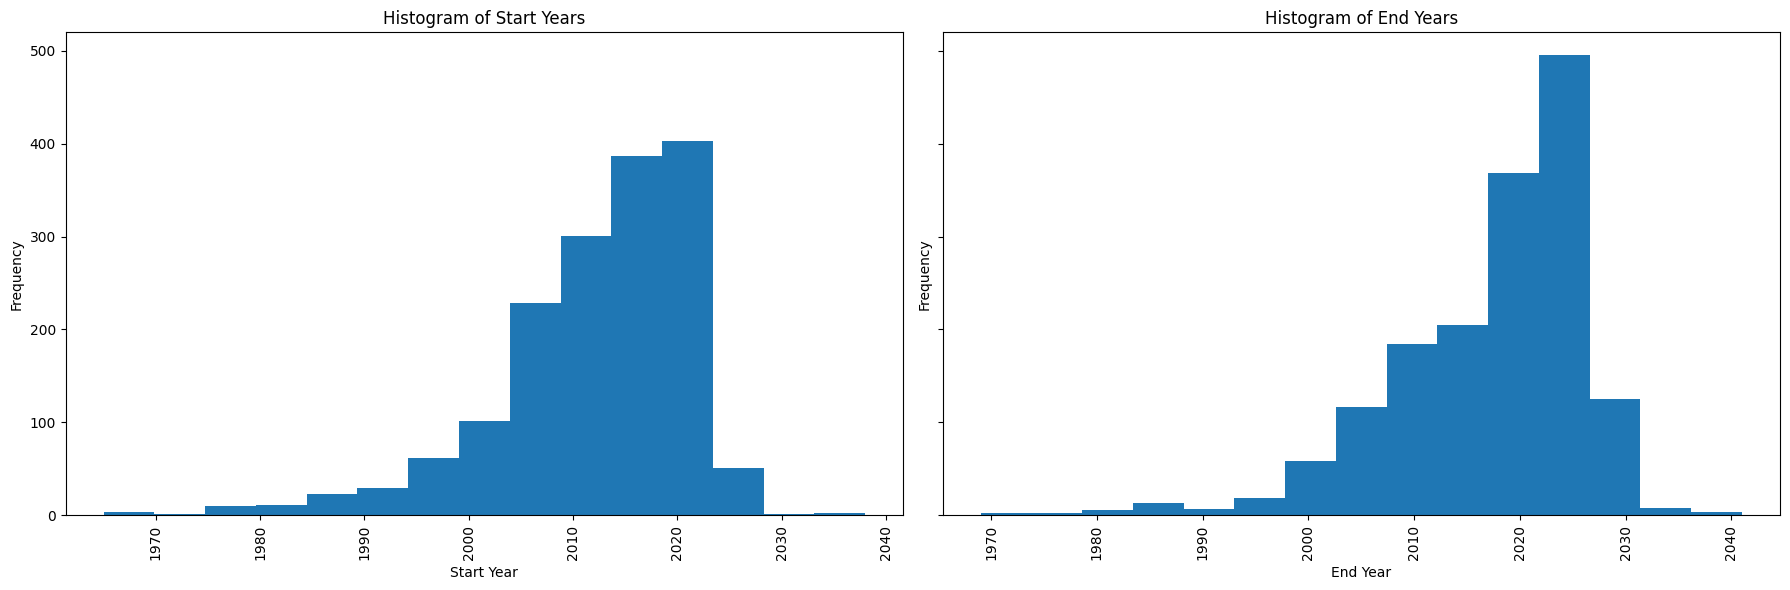

In [5]:
n_bins = 15

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18, 6))

plt.subplots_adjust(wspace=.1)

axs[0].hist(df['start_year'], bins=n_bins)
axs[1].hist(df['end_year'], bins=n_bins)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

axs[0].set_xlabel('Start Year')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Start Years')

axs[1].set_xlabel('End Year')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of End Years')

plt.show()

Both distributions shown above are relatively normal. It's difficult to identify a skew, however both plots have a long tail towards the left. This is logical as projects are less likely to be planned 20 years into the future.

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48591/4145860887.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


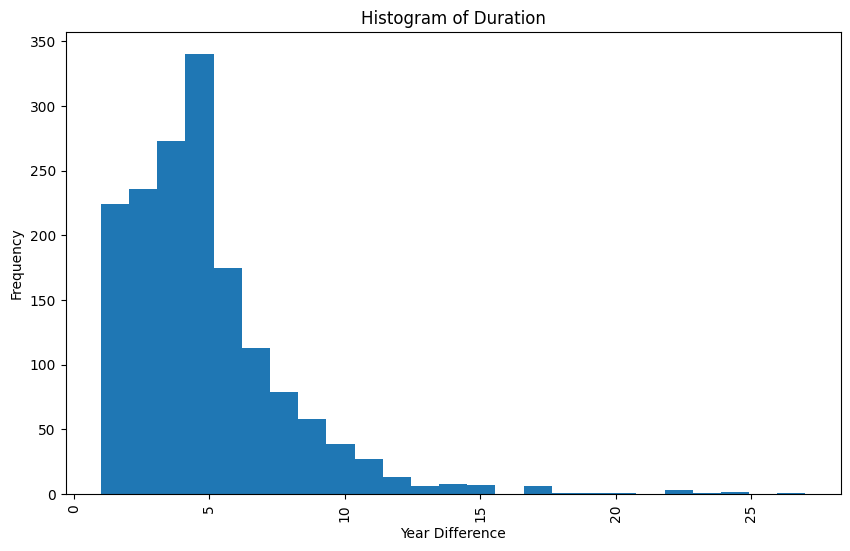

In [6]:
n_bins = 25

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1)

axs.hist(df['duration'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.set_xlabel('Year Difference')
axs.set_ylabel('Frequency')
axs.set_title('Histogram of Duration')

plt.show()

This distribution is much more normal than the previous two plots. This is a good sign, however it's important to remember that many of our projects have not yet been completed and the above dates are projections. It's possible that delays will occur and the distribution will become (accurately) less normal than displayed above.

### Length Components

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48591/2254531849.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


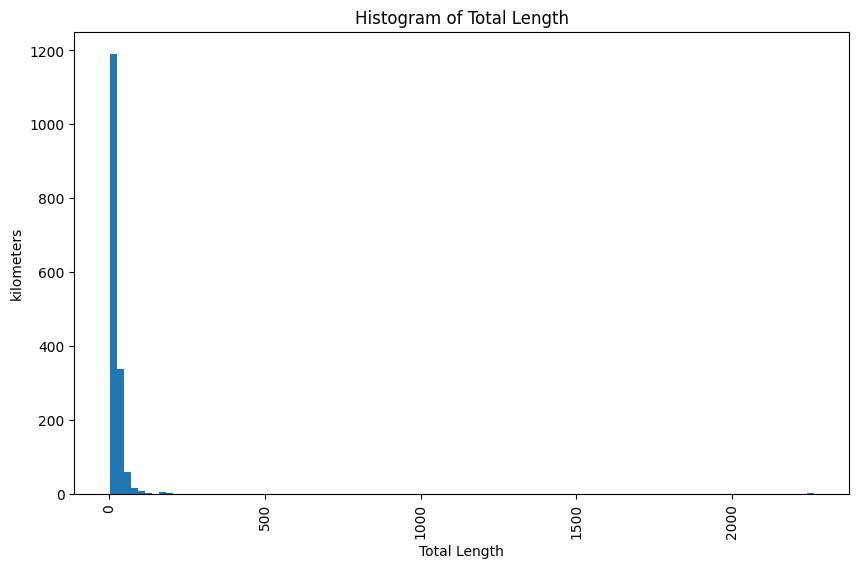

In [7]:
n_bins = 100

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1)  # Adjust the horizontal space between subplots

axs.hist(df['length'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Total Length')

plt.show()

From the above histogram we see that, generally, the total length component is relatively tightly grouped with a single outlier far and away longer than the other projects. Let's remove this outlier from this histogram and then replot

In [8]:
total_length_hist = df[df['length'] < 2000]

In [9]:
total_length_hist

country          city  start_year  end_year  rr?  length  tunnel_per  \
0         HK     Hong Kong        2000      2005  0.0   1.300         0.0   
1         DE        Berlin        1968      1974  0.0   1.500         1.0   
2         CN       Beijing        2007      2013  0.0   4.447         1.0   
3         CN       Beijing        2019      2021  0.0   3.600         1.0   
4         FR          Lyon        2005      2007  0.0   1.000         1.0   
...      ...           ...         ...       ...  ...     ...         ...   
1667      ES       Seville        2024      2026  0.0   1.500         0.0   
1668      NZ  Christchurch        2021      2022  0.0   0.500         0.0   
1669      AU      Canberra        2023      2026  0.0   1.700         0.0   
1670      CO      Medellin        2023      2027  0.0  13.100         0.0   
1671      CL      Santiago        2019      2027  0.0  26.000         0.0   

      tunnel  elevated  at_grade  stations  max_speed track_gauge  overhead?  \
0      0.000       1.3       0.0       1.0       80.0        1432          0   
1      1.500       0.0       0.0       2.0       80.0        1435          0   
2      4.447       0.0       0.0       6.0      100.0        1435          0   
3      3.600       0.0       0.0       3.0      100.0        1435          0   
4      1.000       0.0       0.0       1.0       80.0        1435          0   
...      ...       ...       ...       ...        ...         ...        ...   
1667   0.000       0.0       1.5       2.0       80.0        1435          1   
1668   0.000       0.0       0.5       1.0       30.0        1067          1   
1669   0.000       0.0       1.7       2.0       70.0        1435          0   
1670   0.000       0.0      13.1      14.0       80.0        1435          1   
1671   0.000       0.0      26.0      19.0       90.0        1435          1   

            cost currency  year  ppp_rate    cost_real      cost_km  c_length  \
0          18700      HKD  2003  0.166983  3122.576663  2401.982049       0.0   
1           61.2       DM  1971  0.759851    46.502863    31.001909       0.0   
2       4780.525      CNY  2010  0.300403  1436.081706   322.932698       0.0   
3           2880      CNY  2020  0.239311   689.216325   191.448979       0.0   
4             53      EUR  2006  1.117637    59.234754    59.234754       0.0   
...          ...      ...   ...       ...          ...          ...       ...   
1667         132      EUR  2025  1.644153   217.028161   144.685441       1.5   
1668           9      NZD  2022  0.682895     6.146051    12.292101       0.0   
1669         294      AUD  2025  0.704593   206.893990   121.702347       0.0   
1670     3021494      COP  2025  0.000719  2172.174214   165.814826       0.0   
1671  2315323.14      CHP  2023  0.002255  5221.559260   200.829202       0.0   

      c_tunnel  anglo  inflation_index  cost_real_2023  cost_km_2023  \
0          0.0      0         1.483402     4632.035892   3563.104532   
1          0.0      0         6.739406      313.401664    208.934443   
2          0.0      0         1.251724     1797.577974    404.222616   
3          0.0      0         1.054615      726.857798    201.904944   
4          0.0      0         1.353898       80.197844     80.197844   
...        ...    ...              ...             ...           ...   
1667       0.0      0         0.970410      210.606202    140.404135   
1668       0.0      1         1.015482        6.241206     12.482413   
1669       0.0      1         0.970410      200.771905    118.101121   
1670       0.0      0         0.970410     2107.898620    160.908292   
1671       0.0      0         1.000000     5221.559260    200.829202   

      train_type project_type  duration  
0            MRT    Extension         5  
1            MRT    Extension         6  
2            MRT    Extension         6  
3            MRT          New         2  
4            MRT    Extension         2  
...          ...          ...

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48591/1385921891.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


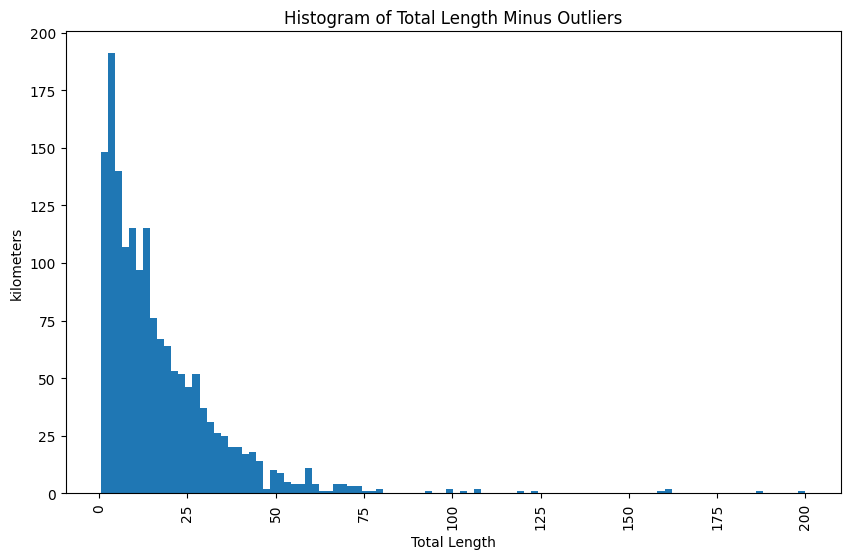

In [10]:
n_bins = 100

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1)
axs.hist(total_length_hist['length'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Total Length Minus Outliers')

plt.show()

Now we can see more clearly that the projects are all fairly tightly grouped between 0 and 50km. This is a reasonable grouping as it's more likely that a project phase will be broken into smaller components and executed individually in phases.

Let's do the same for the tunnel component

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48591/572999720.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


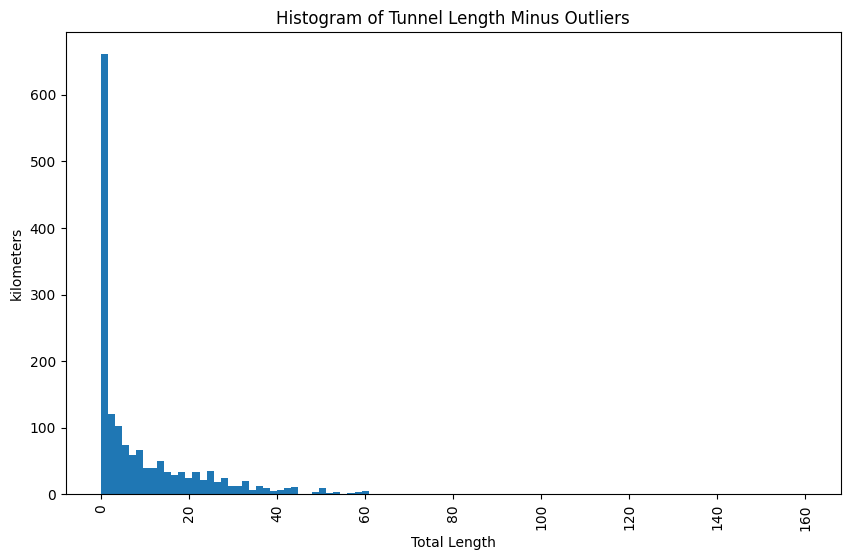

In [11]:
n_bins = 100

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1) 
axs.hist(total_length_hist['tunnel'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Tunnel Length Minus Outliers')

plt.show()

This time we'll need to look at only the projects that have a tunneling component

In [12]:
tunnel_length_hist = df[df['tunnel'] > 0]

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48591/572999720.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


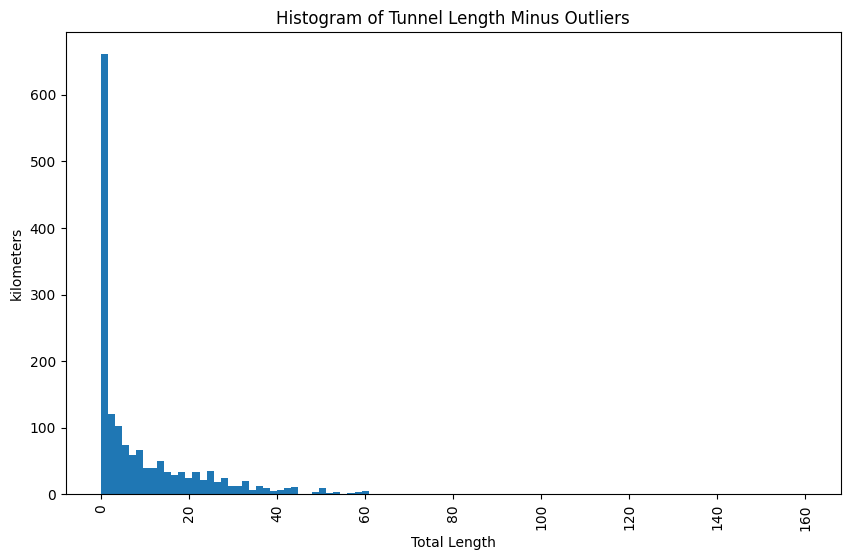

In [13]:
n_bins = 100

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1) 
axs.hist(total_length_hist['tunnel'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Tunnel Length Minus Outliers')

plt.show()

There is not much observable difference between the last two plots, however they are both reasonable distributions given the real life implications of tunneling

### Cost Components

Before we continue to analyze the data in subsequent sheets, I want to make sure that the cost components have a reasonable distribution and that there aren't any significant outliers. This feature was difficult to evaluate previously as the dollar value of a project can vary so widely from project to project.

For this section, we'll use the real cost per km as this represents the best normalized version of the target variable.

In [14]:
df['cost_km_2023']

0       3563.104532
1        208.934443
2        404.222616
3        201.904944
4         80.197844
           ...     
1667     140.404135
1668      12.482413
1669     118.101121
1670     160.908292
1671     200.829202
Name: cost_km_2023, Length: 1614, dtype: float64

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48591/422255439.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


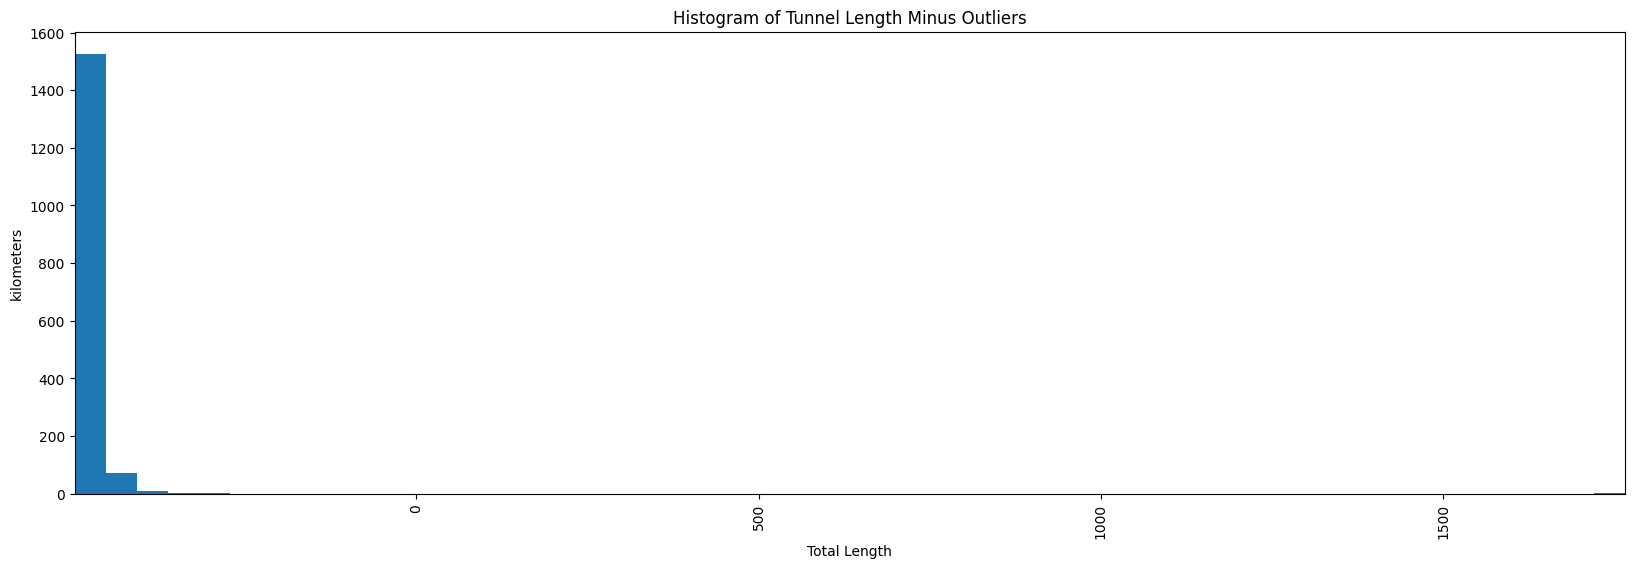

In [15]:
n_bins = 50

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots

axs.hist(df['length'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Tunnel Length Minus Outliers')
min_x = df['length'].min()
max_x = df['length'].max()
axs.set_xlim(min_x, max_x)
plt.show()

#### Upper-End Outliers

One datapoint I'll remove before proceeding is in the 'length' feature. There was one aggregious outlier of length 2000 that isn't representative of the dataset.

In [16]:
df['length'].describe()

count    1614.000000
mean       18.756767
std        58.765438
min         0.500000
25%         5.300000
50%        12.550000
75%        23.900000
max      2265.000000
Name: length, dtype: float64

In [17]:
df['cost_km_2023'].astype('int')

0       3563
1        208
2        404
3        201
4         80
        ... 
1667     140
1668      12
1669     118
1670     160
1671     200
Name: cost_km_2023, Length: 1614, dtype: int64

In [18]:
df[df['cost_km_2023'] >1000].sort_values(by='cost_km_2023',ascending=False)

country          city  start_year  end_year  rr?     length  tunnel_per  \
1609      BY         Minsk        2014      2023  0.0  17.200000    1.000000   
1588      VE      Valencia        1994      2006  0.0   4.300000    1.000000   
1174      AR  Buenos Aires        1990      1995  1.0  15.500000    0.000000   
1330      MY       Malacca        2006      2010  0.0   1.600000    0.000000   
866       US      New York        2007      2022  1.0   2.800000    1.000000   
0         HK     Hong Kong        2000      2005  0.0   1.300000    0.000000   
1570      TW        Taipei        1989      1996  0.0  10.500000    0.000000   
1148      CO      Medellin        1984      1996  0.0   4.300000    0.000000   
1149      CO      Medellin        1984      1996  0.0   5.600000    0.000000   
778       US      New York        2019      2029  0.0   2.600000    1.000000   
912       TW        Taipei        1988      2012  0.0  93.900000    0.648562   
1325      FR         Paris        1998      2003  0.0   0.700000    1.000000   
608       US      New York        2007      2016  0.0   2.700000    1.000000   
902       EG         Cairo        2007      2024  0.0  41.300000    0.000000   
402       TW        Taipei        2002      2013  0.0   6.500000    1.000000   
378       US      New York        2007      2014  0.0   1.600000    1.000000   
1335      PH        Manila        2015      2024  0.0   3.000000    0.000000   
463       HK     Hong Kong        2023      2029  0.0   1.800000    1.000000   
875       TW     Kaohsiung        2001      2008  0.0  43.000000    0.739535   
163       CN      Shanghai        2000      2004  0.0   1.200000    0.000000   
1143      CO        Bogota        2020      2024  0.0  15.500000    0.909091   
574       TW        Taipei        2002      2009  0.0  14.800000    0.256757   
766       TW     Kaohsiung        2008      2018  1.0  15.400000    1.000000   
1563      TW        Taipei        2014      2025  0.0   9.500000    1.000000   
1610      BY         Minsk        2012      2014  0.0   5.000000    1.000000   
697       SG     Singapore        2017      2025  0.0   4.000000    1.000000   
1549      TW        Taipei        2023      2031  0.0   5.500000    0.500000   
1571      TW        Taipei        2023      2032  0.0   5.500000    0.000000   
892       KR         Seoul        1978      1982  0.0  50.200000    0.800000   
1548      TW        Taipei        2018      2024  0.0  17.044928    0.500000   
104       TW        Taipei        2016      2022  0.0   1.400000    1.000000   
486       HK     Hong Kong        2009      2016  0.0   3.000000    1.000000   
1321      FR         Paris        1989      1998  0.0   8.700000    1.000000   
1491      KR         Seoul        2021      2028  0.0   9.050000    1.000000   
782       TW        Taipei        2019      2030  1.0  17.900000    1.000000   
176       TR      Istanbul        2015      2023  0.0   8.900000    0.943820   
867       PE          Lima        2014      2025  0.0  35.000000    1.000000   
899       UK        London        2009      2021  1.0  21.000000    1.000000   
1370      US      Montreal        2020      2029  0.0   6.000000    1.000000   
617       TW        Taipei        2011      2020  0.0  15.400000    0.071429   
210       TR         Izmir        1995      2000  0.0  11.600000    0.293103   
823       AU     Melbourne        2018      2025  0.0   9.000000    1.000000   

         tunnel   elevated  at_grade  stations  max_speed track_gauge  \
1609  17.200000   0.000000       0.0       7.0       80.0        1520   
1588   4.300000   0.000000       0.0       5.0       60.0        1435   
1174   0.000000   0.000000      15.5      11.0       30.0        1435   
1330   0.000000   1.600000       0.0       3.0       50.0           0   
866    2.800000   0.000000       0.0       1.0       70.0        1435   
0      0.000000   1.300000       0.0       1.0       80.0        1432   
1570   0.000000  10.500000       0.0      12.0       

There's several projects that are outliers, at least at first glance. I'll make note and review these data points in section 06. The outliers don't seem to be erroneous and so I'll leave them in for the time being.

#### Lower-End Outliers

In [19]:
df[df['cost_km_2023'] <15].sort_values(ascending = True, by = 'cost_km_2023')

country            city  start_year  end_year  rr?       length  \
1092      CO          Bogota        2020      2024  1.0    39.735898   
1147      CO        Medellin        2013      2015  0.0     1.400000   
1146      CO        Medellin        2013      2015  0.0     1.400000   
1145      CO        Medellin        2013      2015  0.0     1.056000   
1142      CO          Bogota        2014      2025  0.0    24.140000   
727       EG           Egypt        2018      2024  0.0  2265.000000   
1625      US       Galveston        2017      2021  0.0     4.852895   
1328      BR          Maceio        2015      2021  0.0     2.400000   
1269      JP      Kitakyushu        1992      1998  0.0     8.800000   
1462      US      Santa Cruz        2018      2020  1.0    33.005000   
1643      AR         Mendoza        2009      2012  0.0    17.063882   
1428      BR          Recife        2015      2021  0.0     4.200000   
1463      US      Santa Cruz        2018      2020  1.0    15.456000   
1461      US      Santa Cruz        2018      2020  1.0    10.626000   
1464      US      Santa Cruz        2018      2020  1.0    12.171600   
1133      ES          Bilbao        2020      2021  0.0     2.300000   
1345      US           Miami        2018      2023  0.0    14.325540   
1296      US     Little Rock        2001      2004  0.0     5.500000   
1435      MX     Guadalajara        2014      2020  0.0    21.500000   
1599      SE      Norrköping        2007      2010  1.0     4.000000   
1247      DE     Saarbrucken        2009      2014  0.0    10.400000   
1537      AU       Melbourne        2004      2005  0.0     0.940000   
1097      FR            Lyon        2007      2010  0.0    22.000000   
398       EG           Cairo        2019      2025  0.0    19.000000   
881       EG           Cairo        2019      2025  0.0    19.000000   
1596      IT          Venice        2004      2014  0.0     6.000000   
1597      IT          Venice        2004      2014  0.0    14.000000   
1577      JP          Toyama        2004      2006  0.0     6.500000   
1591      FR    Valenciennes        2011      2013  0.0    14.986189   
1536      AU       Melbourne        2004      2005  0.0     3.000000   
1361      IT           Padua        2003      2009  0.0    10.300000   
1522      US       St. Louis        2023      2025  0.0     8.400000   
1418      US        Portland        1999      2001  0.0     7.700000   
1193      IT        Cagliari        2004      2008  0.0     6.400000   
1374      US     New Orleans        2014      2016  0.0     3.900000   
1342      AR         Mendoza        2012      2014  0.0     5.400000   
1668      NZ    Christchurch        2021      2022  0.0     0.500000   
1553      US           Tampa        2008      2010  0.0     0.540000   
1329      BR          Maceio        2015      2021  0.0     3.700000   
1238      US         El Paso        2015      2018  0.0     7.723243   
1038      IT           Milan        2023      2025  0.0    14.497996   
1308      FR            Lyon        2010      2012  0.0     6.400000   
1535      AU       Melbourne        2001      2003  0.0     2.200000   
1299      DE          Berlin        2007      2011  0.0     1.400000   
1452      US  Salt Lake City        2012      2013  0.0     4.410000   

      tunnel_per  tunnel   elevated     at_grade  stations  max_speed  \
1092    0.000000     0.0   0.000000    39.735898      17.0       70.0   
1147    0.000000     0.0   0.000000     1.400000       3.0       40.0   
1146    0.000000     0.0   0.000000     1.400000       3.0       40.0   
1145    0.000000     0.0   0.000000     1.056000       3.0       40.0   
1142    0.000000     0.0  24.140000     0.000000      16.0       70.0   
727     0.000000     0.0   0.000000  2265.000000      62.0      200.0   
1625    0.000000     0.0   0.000000     4.852895      22.0       40.0   
1328    0.000000     0.0   0.000000     2.400000       1.0       90.0   
1269    0.000000     0.0   8.800000

All of the low end data points are from Beijing. Again, I'll make note and address these in section 06.

### Economic & Monetary Indicators

Within the dataset, the real cost is a calculated value that is a function of the stated cost of a project multiplied by two factors: PPP rate (purchasing power parity & inflation rate). For the sake of brevity, I've outlined the purpose of these factors in the introduction section. However, since these factors determine the magnitude of the target feature, it's important that we check both to ensure there aren't any erroneous values in the dataset.

##### PPP Rate

For this section, I intend to evaluate the distribution of the PPP rate and then validate the factor provided in the dataset.

In [20]:
df.sort_values(by='ppp_rate', ascending= False)

country              city  start_year  end_year  rr?  length  tunnel_per  \
1270      TR             Konya        1996      1999  0.0    18.5    0.000000   
210       TR             Izmir        1995      2000  0.0    11.6    0.293103   
358       BH           Bahrain        2018      2024  1.0    28.6    0.000000   
800       BH           Bahrain        2020      2025  1.0    72.7    0.000000   
910       KW       Kuwait City        2020      2025  0.0   160.0    0.350000   
...      ...               ...         ...       ...  ...     ...         ...   
390       VN             Hanoi        2011      2020  0.0    11.5    0.739130   
700       VN  Ho Chi Minh City        2012      2021  0.0    19.7    0.131980   
376       IR            Tehran        2012      2014  0.0    12.0    1.000000   
725       IR            Tehran        2015      2017  0.0    27.0    1.000000   
724       IR            Tehran        2015      2019  0.0    31.0    1.000000   

      tunnel  elevated  at_grade  stations  max_speed track_gauge  overhead?  \
1270     0.0      0.00      18.5      18.0       70.0        1435          1   
210      3.4      0.00       8.2      10.0       70.0        1435          0   
358      0.0     28.60       0.0      20.0       65.0        1435          1   
800      0.0     72.70       0.0      18.0       65.0        1435          1   
910     56.0    104.00       0.0      68.0       60.0        1435          1   
...      ...       ...       ...       ...        ...         ...        ...   
390      8.5      2.99       0.0      12.0       80.0        1435          0   
700      2.6     17.10       0.0      14.0       80.0        1435          1   
376     12.0      0.00       0.0      11.0       80.0        1435          0   
725     27.0      0.00       0.0      25.0       80.0        1435          0   
724     31.0      0.00       0.0      29.0       80.0        1435          0   

          cost currency  year  ppp_rate     cost_real     cost_km  c_length  \
1270     754.8      TRY  1998  7.759818   5857.110709  316.600579      18.5   
210        900      TRY  1998  7.759818   6983.836299  602.054853      11.6   
358        453       BD  2021  5.436123   2462.563775   86.103629       0.0   
800       1500       BD  2023  5.400636   8100.953413  111.429896       0.0   
910       6000      KWD  2023  4.384825  26308.948980  164.430931       0.0   
...        ...      ...   ...       ...           ...         ...       ...   
390   19555000      VND  2016  0.000137   2673.050167  232.439145       0.0   
700   43600000      VND  2017  0.000135   5895.605822  299.269331       0.0   
376   20000000      IRR  2013  0.000118   2351.876833  195.989736       0.0   
725   90000000      IRR  2016  0.000085   7629.180755  282.562250       0.0   
724   90000000      IRR  2017  0.000077   6890.587843  222.277027       0.0   

      c_tunnel  anglo  inflation_index  cost_real_2023  cost_km_2023  \
1270       0.0      0         1.674515     9807.819347    530.152397   
210        3.4      0         1.674515    11694.538170   1008.149842   
358        0.0      0         1.007292     2480.520980     86.731503   
800        0.0      0         1.000000     8100.953413    111.429896   
910        0.0      0         1.000000    26308.948980    164.430931   
...        ...    ...              ...             ...           ...   
390        0.0      0         1.137242     3039.903731    264.339455   
700        0.0      0         1.113520     6564.872870    333.242278   
376        0.0      0         1.171658     2755.595320    229.632943   
725        0.0      0         1.137242     8676.221391    321.341533   
724        0.0      0         1.113520     7672.804892    247.509835   

      train_type project_type  duration  
1270     Tramway    Extension         3  
210          MRT          New         5  
358   Light Rail          New         6  
800   Light Rail          New         5  
910   Light Rail          New         5  
...  

In [21]:
df[df['ppp_rate'] > 4]

country         city  start_year  end_year  rr?  length  tunnel_per  \
210       TR        Izmir        1995      2000  0.0    11.6    0.293103   
358       BH      Bahrain        2018      2024  1.0    28.6    0.000000   
800       BH      Bahrain        2020      2025  1.0    72.7    0.000000   
910       KW  Kuwait City        2020      2025  0.0   160.0    0.350000   
1270      TR        Konya        1996      1999  0.0    18.5    0.000000   

      tunnel  elevated  at_grade  stations  max_speed track_gauge  overhead?  \
210      3.4       0.0       8.2      10.0       70.0        1435          0   
358      0.0      28.6       0.0      20.0       65.0        1435          1   
800      0.0      72.7       0.0      18.0       65.0        1435          1   
910     56.0     104.0       0.0      68.0       60.0        1435          1   
1270     0.0       0.0      18.5      18.0       70.0        1435          1   

       cost currency  year  ppp_rate     cost_real     cost_km  c_length  \
210     900      TRY  1998  7.759818   6983.836299  602.054853      11.6   
358     453       BD  2021  5.436123   2462.563775   86.103629       0.0   
800    1500       BD  2023  5.400636   8100.953413  111.429896       0.0   
910    6000      KWD  2023  4.384825  26308.948980  164.430931       0.0   
1270  754.8      TRY  1998  7.759818   5857.110709  316.600579      18.5   

      c_tunnel  anglo  inflation_index  cost_real_2023  cost_km_2023  \
210        3.4      0         1.674515    11694.538170   1008.149842   
358        0.0      0         1.007292     2480.520980     86.731503   
800        0.0      0         1.000000     8100.953413    111.429896   
910        0.0      0         1.000000    26308.948980    164.430931   
1270       0.0      0         1.674515     9807.819347    530.152397   

      train_type project_type  duration  
210          MRT          New         5  
358   Light Rail          New         6  
800   Light Rail          New         5  
910   Light Rail          New         5  
1270     Tramway    Extension         3

As we see, there is a subset of the data where the PPP_rate is signficantly larger than 3. Given the countries involved, this is reasonable but I'd like to verify some of these values independently.

- Bahrain, index 358 & index 800: According to the data, in the year 2018, Bahrain had a PPP_rate of .2 (factor of 5). This data matches up with the UN PPP conversion factor, GDP (LCU per international $)
- Uzbekistan, index 110 & index 129: According to data provided by the UN, the stated rate of 5 is reasonable

One other important thing to note is that many countries that are listed in the dataset are transacting in currencies outside of their local currency. This changes the calculation of the real cost and, since I'm not an economist, is likely a blind spot/source of error for me.

All I can hope to do is evaluate the data with a model and see if the results are reasonable.

****After modelling, this was a source of error. My solution was to convert all the currencies into their native currency, which I believe resolved the unmatched PPP rate and country currency issue****

##### Inflation Index

In [22]:
df.sort_values(by='inflation_index', ascending= False)

country        city  start_year  end_year  rr?     length  tunnel_per  \
30        CN     Beijing        1965      1969  0.0  23.600000    1.000000   
1265      JP    Kamakura        1965      1970  0.0   4.746071    0.000000   
50        DE      Munich        1965      1971  1.0  11.400000    0.359649   
1         DE      Berlin        1968      1974  0.0   1.500000    1.000000   
1360      US  Morgantown        1974      1975  0.0   8.400000    0.000000   
...      ...         ...         ...       ...  ...        ...         ...   
1546      US      Tacoma        2026      2035  0.0  15.779795    0.000000   
1489      US     Seattle        2026      2039  0.0  12.320000    0.487013   
1488      US     Seattle        2030      2037  0.0  26.200000    0.000000   
1545      US      Tacoma        2035      2041  0.0   5.600000    0.000000   
1268      US    Kirkland        2038      2041  0.0  11.800000    0.000000   

      tunnel   elevated  at_grade  stations  max_speed track_gauge  overhead?  \
30      23.6   0.000000   0.00000      17.0      100.0        1435          0   
1265     0.0   4.746071   0.00000       8.0       75.0           0          0   
50       4.1   0.000000   7.30000       5.0       80.0        1435          1   
1        1.5   0.000000   0.00000       2.0       80.0        1435          0   
1360     0.0   8.400000   0.00000       4.0       40.0           0          0   
...      ...        ...       ...       ...        ...         ...        ...   
1546     0.0  14.201816   1.57798       2.0       90.0        1435          1   
1489     6.0   5.320000   1.00000       9.0       90.0        1435          1   
1488     0.0  13.100000  13.10000       6.0       90.0        1435          1   
1545     0.0   0.000000   5.60000       6.0       40.0        1435          1   
1268     0.0   2.360000   9.44000       8.0       90.0        1435          1   

         cost currency  year  ppp_rate    cost_real     cost_km  c_length  \
30        700      CNY  1967  0.374779   262.345118   11.116319       0.0   
1265  8888.89      JPY  1968  0.004707    41.839135    8.815531       0.0   
50        459       DM  1968  0.764430   350.873170   30.778348       0.0   
1        61.2       DM  1971  0.759851    46.502863   31.001909       0.0   
1360       62      USD  1975  1.000000    62.000000    7.380952       0.0   
...       ...      ...   ...       ...          ...         ...       ...   
1546     3300      USD  2031  1.000000  3300.000000  209.128186       0.0   
1489     8000      USD  2033  1.000000  8000.000000  649.350649       0.0   
1488     6500      USD  2034  1.000000  6500.000000  248.091603       0.0   
1545      478      USD  2038  1.000000   478.000000   85.357143       0.0   
1268     1900      USD  2040  1.000000  1900.000000  161.016949       0.0   

      c_tunnel  anglo  inflation_index  cost_real_2023  cost_km_2023  \
30         0.0      0         8.172034     2143.893212     90.842933   
1265       0.0      0         7.843274      328.155801     69.142624   
50         0.0      0         7.843274     2751.994398    241.403017   
1          0.0      0         6.739406      313.401664    208.934443   
1360       0.0      1         5.073344      314.547359     37.446114   
...        ...    ...              ...             ...           ...   
1546       0.0      1         0.882047     2910.755837    184.460936   
1489       0.0      1         0.857534     6860.271057    556.840183   
1488       0.0      1         0.845781     5497.577502    209.831202   
1545       0.0      1         0.801824      383.272016     68.441431   
1268       0.0      1         0.781516     1484.880150    125.837301   

      train_type project_type  duration  
30           MRT          New         4  
1265    Monorail          New         5  
50           MRT          New         6  
1            MRT    Extension         6  
1360         APM          New         1  
...          ...          ...       ...  
1546       

This is another section I'll have to revisit if the results are not reasonable. I don't believe plotting the data in a histogram would be beneficial as the inflation index is an abstracted financial instrument.

In [23]:
df['track_gauge'] = df['track_gauge'].str.replace(',', '').astype(float)

In [24]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [country, city, start_year, end_year, rr?, length, tunnel_per, tunnel, elevated, at_grade, stations, max_speed, track_gauge, overhead?, cost, currency, year, ppp_rate, cost_real, cost_km, c_length, c_tunnel, anglo, inflation_index, cost_real_2023, cost_km_2023, train_type, project_type, duration]
Index: []

### Section Conclusion

Within this section I evaluated the data with the intent to verify that the dataset was representative. The purpose of this task was to improve the model's ability to predict unseen data and creating more normally distributed features is a good first step. Many of these tasks will be expanded upon as I get further into the modelling process in future sheets.

### Dataframe Export

In [25]:
with open('pickles/df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [26]:
df.shape

(1614, 29)